<a href="https://colab.research.google.com/github/howkeye/new/blob/master/yolov_deepsort_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Loading files from drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/python/yolo')


In [3]:
!ls

 cd		 LICENSE	     stitch.ipynb     Viz
 convert.py	 model_data	     test_frame.png   yolo3
 deep_sort	 __pycache__	     testgpu.py       yolo.py
 demo.py	 qmul_junction.png   tools	      yolo.pyc
 detection.txt	 README.md	     video1.mp4       yolov3.cfg
 gpudevices.py	 Results	     video.mp4	     'yolov_deepsort (1).ipynb'


# Imports and Defaults

In [4]:
from __future__ import division, print_function, absolute_import

import os
from timeit import time
import warnings
import sys
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output

from PIL import Image
from yolo import YOLO

from deep_sort import preprocessing
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker
from tools import generate_detections as gdet
from deep_sort.detection import Detection as ddet
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

MAX_COSINE_DISTANCE = 0.3
NN_BUDGET = None
NMS_MAX_OVERLAP = 1.0

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


# Getting YOLO Object

In [5]:
yolo = YOLO()













model_data/yolo.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Definition of the parameters

[What these params are?](https://github.com/nwojke/deep_sort/blob/master/deep_sort/nn_matching.py)

[max_bbox_overlap](https://github.com/nwojke/deep_sort/blob/master/application_util/preprocessing.py)


        matching threshold: Samples with larger distance are considered an
        invalid match.
        
        budget : int
        If not None, fix samples per class to at most this number. Removes
        the oldest samples when the budget is reached.
        
        max_bbox_overlap : float
        ROIs that overlap more than this values are suppressed.

In [0]:
matching_threshold = 0.2
nn_budget = None
nms_max_overlap = 0.7

# deep_sort 

In [7]:
model_filename = 'model_data/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename,batch_size=1)

metric = nn_matching.NearestNeighborDistanceMetric("cosine", matching_threshold, nn_budget)
tracker = Tracker(metric)

# Input Video File

In [8]:
input_file_name = 'video'
input_file_format='.mp4'
path =input_file_name+input_file_format
video_capture = cv2.VideoCapture(path)

width_video_frame = int(video_capture.get(3))
height_video_frame = int(video_capture.get(4))
print(height_video_frame,width_video_frame)

288 360


# Trajectory Dataset Output Folder

In [0]:
name = 'v1'

In [10]:
out_directory = './Results/'+input_file_name+'_'+name
if not os.path.exists(out_directory):
    os.mkdir(out_directory)
    print("Directory " , out_directory ,  " Created ")
else:
    print("Directory " , out_directory ,  " already exists")
    
#trajectories folder
out_trajectories_directory = out_directory+'/OldTrajectories'   
if not os.path.exists(out_trajectories_directory):
    os.mkdir(out_trajectories_directory)
    print("Directory " , out_trajectories_directory ,  " Created ")
else:
    print("Directory " , out_trajectories_directory ,  " already exists")
    

Directory  ./Results/video_v1  already exists
Directory  ./Results/video_v1/OldTrajectories  already exists


##  Saving HyperParameters

In [0]:
from configparser import SafeConfigParser

config = SafeConfigParser()
config.read('config.ini')
config.add_section('Video')
config.set('Video', 'path', path)
config.add_section('NN_Matching')
config.set('NN_Matching', 'matching_threshold', str(matching_threshold))
config.set('NN_Matching', 'nn_budget', str(nn_budget))
config.add_section('Preprocessing')
config.set('Preprocessing', 'nms_max_overlap', str(nms_max_overlap))

with open(out_directory+'/'+'model_config.ini', 'w') as f:
    config.write(f)



#Crop Parameters

## Judging the crop frame

In [12]:
!ls

 cd		 LICENSE	     stitch.ipynb     Viz
 convert.py	 model_data	     test_frame.png   yolo3
 deep_sort	 __pycache__	     testgpu.py       yolo.py
 demo.py	 qmul_junction.png   tools	      yolo.pyc
 detection.txt	 README.md	     video1.mp4       yolov3.cfg
 gpudevices.py	 Results	     video.mp4	     'yolov_deepsort (1).ipynb'


(288, 360, 3)


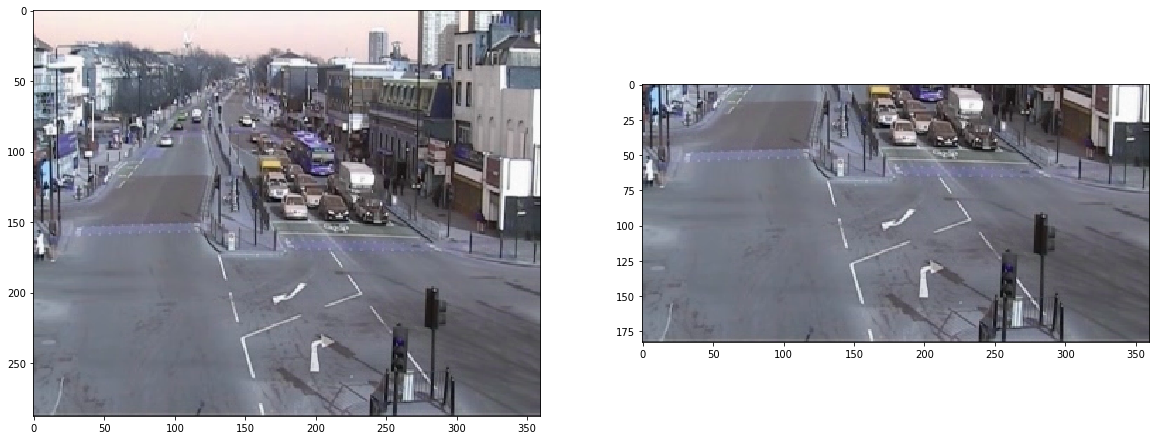

In [13]:
# test_frame = cv2.imread('test_frame.png')
test_frame = cv2.imread('qmul_junction.png')

plt.figure(figsize=(20,24))
plt.subplot(1, 2, 1)
plt.imshow(test_frame)
print(test_frame.shape)

c_start_h, c_end_h = 105,height_video_frame
c_start_w, c_end_w = 0, width_video_frame

# crop_frame = test_frame[100:height_video_frame, 0:615]
crop_frame = test_frame[c_start_h:c_end_h, c_start_w:c_end_w]
plt.subplot(1, 2, 2)
plt.imshow(crop_frame)
plt.show()


## Crop Parameters

In [0]:
crop_flag = False

In [0]:
if crop_flag:
  ( height_start , width_start )  = (c_start_h, c_start_w)
  ( height_end,  width_end ) = (c_end_h , c_end_w)

## Function 

In [0]:
def crop_frame(frame, height_start, width_start, height_end, width_end):
  return frame[height_start:height_end, width_start:width_end]

# Generate Output Video

In [0]:
writeVideo_flag = True

In [0]:
if writeVideo_flag:
# Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
  
    #output_video_height = height_end-height_start
    #output_video_width = width_end - width_start
    
    if crop_flag:
      out = cv2.VideoWriter(out_directory+'/output_'+input_file_name+'gg.avi', fourcc, 15, (output_video_width, output_video_height))
    else:
      out = cv2.VideoWriter(out_directory+'/output_'+input_file_name+'gg.avi', fourcc, 15, (width_video_frame, height_video_frame))
    
    frame_index = -1 

#Extract Trajectories

In [19]:
fps = 0.0
while True:
    ret, frame = video_capture.read()  # frame shape 640*480*3
    if ret != True:
        break;
        
    t1 = time.time()
    
    if crop_flag:
      frame = crop_frame(frame, height_start ,width_start , height_end, width_end)
    
    image = Image.fromarray(frame)
    boxs = yolo.detect_image(image)
    features = encoder(frame,boxs)

    # score to 1.0 here).
    detections = [Detection(bbox, 1.0, feature) for bbox, feature in zip(boxs, features)]

    # Run non-maxima suppression.
    boxes = np.array([d.tlwh for d in detections])
    scores = np.array([d.confidence for d in detections])
    indices = preprocessing.non_max_suppression(boxes, nms_max_overlap, scores)
    detections = [detections[i] for i in indices]

    # Call the tracker
    tracker.predict()
    tracker.update(detections)

    for track in tracker.tracks:
        if not track.is_confirmed() or track.time_since_update > 1:
            continue 
        bbox = track.to_tlbr()
        
        #draw rectangle
#         cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),(255,255,255), 2)

        #create trajectory file
        object_file = open(out_trajectories_directory+'/'+str(track.track_id)+'.txt', 'a')

        x = int(bbox[0]+(bbox[2]-bbox[0])/2)
        y = int(bbox[1]+(bbox[3]-bbox[1])/2)
        cv2.putText(frame, str(track.track_id),(x, y),0, 5e-3 * 200, (0,255,0),2)
        
        x_limit = frame.shape[1]
        y_limit = frame.shape[0]
        
        if x<=x_limit and y <=y_limit:
          
            object_file.write(str(x)+ '\t'+str(y)+'\t'+str(frame_index)+'\n') 
            cv2.circle(frame,(x,y), 3, (0,0,255), -1)
           
    for det in detections:
        bbox = det.to_tlbr()
    
    if writeVideo_flag:
        # save a frame
        out.write(frame)
        frame_index = frame_index + 1

    fps  = ( fps + (1./(time.time()-t1))) / 2
    print(fps)

video_capture.release()
if writeVideo_flag:
    out.release()

0.06196002736325214
2.788079655166329
1.6162083038329358
1.6067599786728883
1.6007213129943978
3.558769444884574
2.6656493350286143
4.05465248187756
4.492910496202898
5.091860665241297
5.290570361936567
5.194115380654717
5.342962699636834
5.236475448435719
5.251253118143405
5.290361845640224
5.271334869153781
5.48762007138794
5.27555964123082
5.260531196303254
3.340515966120675
4.037845273752341
4.6853417950506255
4.501200692237967
4.803128468144597
4.891255971554105
5.056949116395904
5.054959769632692
5.092649678920431
5.224881716670631
4.981236914920249
5.2129267868342595
5.200356251266767
5.352663977017795
5.471401720244301
5.37153581376272
5.392388644778919
5.393953942029064
3.563414752731004
4.391338794199802
4.725867298044464
3.270733495612147
4.003224031798509
4.6556838288393525
5.147398024494052
5.097238305370308
5.2671057252163
5.490139971984214
5.255372612940533
5.3920180707822585
5.255759059802807
5.3653113601276665
5.481825466704339
5.29624625514343
5.281525357199801
5.4038

In [0]:
print(out_trajectories_directory)

./Results/93_v1/Trajectories


#Minimum Length Of Trajectory

307.94552658190884


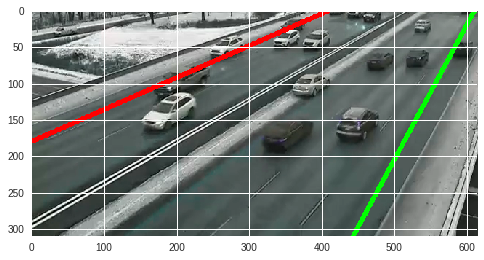

In [0]:
import math
test_frame = cv2.imread('test_frame.png')

crop_frame = test_frame[100:height_video_frame, 0:615]


# Draw lanes
cv2.line(crop_frame,(0,180),(410,0),(255,0,0),5)

cv2.line(crop_frame,(610,0),(440,315),(0,255,0),5)

# dist = math.hypot(x2 - x1, y2 - y1)
min_length = min(math.hypot(440 - 610, 315 - 0),math.hypot(410 - 0, 0 - 180) )
min_length = min_length-50
print(min_length)
plt.imshow(crop_frame)
plt.show()

# Trajectory Preprocessing

In [0]:
!ls ./Results/93_v1

model_config.ini  output_93.avi  Trajectories


In [0]:
refined_trajectories_directory = out_directory+'/Refined_Trajectories' 

if not os.path.exists(refined_trajectories_directory):
    os.mkdir(refined_trajectories_directory)
    print("Directory " , refined_trajectories_directory ,  " Created ")
else:
    print("Directory " , refined_trajectories_directory ,  " already exists")

Directory  ./Results/93_v1/Refined_Trajectories  Created 


In [0]:
for filename in os.listdir(out_trajectories_directory):
  if filename.endswith(".txt"):
      dat = np.loadtxt(out_trajectories_directory+'/'+filename)
      start_x, start_y =  dat[0,0], dat[0,1]
      end_x , end_y = dat[-1,0], dat[-1,1]
      length = math.hypot(end_x - start_x, end_y - start_y)
      if(length> min_length):
        np.savetxt(refined_trajectories_directory+'/'+filename.split('.')[0]+'.txt',dat,fmt='%i')


(416.0, 292.0) | (611.0, 8.0)  -> 3279
(265.0, 284.0) | (589.0, 5.0)  -> 3280
(474.0, 4.0) | (56.0, 196.0)  -> 3282
(232.0, 256.0) | (560.0, 5.0)  -> 3286
(402.0, 291.0) | (611.0, 6.0)  -> 3290
(300.0, 270.0) | (589.0, 5.0)  -> 3291
(427.0, 7.0) | (40.0, 217.0)  -> 3292
(212.0, 262.0) | (561.0, 4.0)  -> 3294
(449.0, 5.0) | (30.0, 175.0)  -> 3297
(481.0, 5.0) | (37.0, 218.0)  -> 3299
(410.0, 4.0) | (9.0, 150.0)  -> 3302
(270.0, 291.0) | (587.0, 5.0)  -> 3306
(169.0, 282.0) | (559.0, 4.0)  -> 3310
(480.0, 4.0) | (33.0, 140.0)  -> 3259
(481.0, 3.0) | (30.0, 213.0)  -> 3315
(409.0, 5.0) | (26.0, 140.0)  -> 3321
(204.0, 268.0) | (560.0, 4.0)  -> 3323
(270.0, 286.0) | (589.0, 5.0)  -> 3325
(230.0, 255.0) | (558.0, 4.0)  -> 3331
(399.0, 18.0) | (32.0, 140.0)  -> 3334
(177.0, 279.0) | (559.0, 4.0)  -> 3342
(297.0, 270.0) | (588.0, 6.0)  -> 3345
(336.0, 41.0) | (29.0, 173.0)  -> 3347
(480.0, 4.0) | (55.0, 207.0)  -> 3350
(197.0, 275.0) | (562.0, 4.0)  -> 3356
(275.0, 293.0) | (587.0, 4.0)  -> 3

##Stiching

In [0]:
for filename in os.listdir(out_trajectories_directory):
  if filename.endswith(".txt"):
      data = np.loadtxt(out_trajectories_directory+'/'+filename,dtype='int')
      
#       x = dat[:,0].astype( np.uint8 )  # this is the X column as float
#       y = dat[:,1].astype( np.uint8 )  # this is the Y column as float
#       f = dat[:,2].astype( np.uint8 )  # this is the F column as int
      
      start_x ,start_y, start_f =  data[0,0], data[0,1], data[0,2]
      end_x , end_y, end_f = data[-1,0], data[-1,1], data[-1,2]
      
      print((start_x,start_y,start_f),'\t', (end_x, end_y,end_f),' \t', filename.split('.')[0])
      

(416, 292, 18530) 	 (611, 8, 18736)  	 3279
(265, 284, 18533) 	 (589, 5, 18688)  	 3280
(474, 4, 18554) 	 (56, 196, 18751)  	 3282
(231, 86, 18554) 	 (35, 172, 18629)  	 3283
(232, 256, 18564) 	 (560, 5, 18736)  	 3286
(361, 19, 18602) 	 (141, 93, 18706)  	 3289
(402, 291, 18602) 	 (611, 6, 18805)  	 3290
(300, 270, 18611) 	 (589, 5, 18767)  	 3291
(427, 7, 18615) 	 (40, 217, 18844)  	 3292
(212, 262, 18627) 	 (561, 4, 18805)  	 3294
(449, 5, 18645) 	 (30, 175, 18900)  	 3297
(481, 5, 18649) 	 (37, 218, 18843)  	 3299
(381, 295, 18655) 	 (397, 275, 18663)  	 3300
(410, 4, 18661) 	 (9, 150, 18858)  	 3302
(448, 226, 18680) 	 (609, 5, 18856)  	 3305
(270, 291, 18684) 	 (587, 5, 18862)  	 3306
(525, 34, 18688) 	 (526, 33, 18690)  	 3309
(169, 282, 18692) 	 (559, 4, 18864)  	 3310
(480, 4, 18412) 	 (33, 140, 18675)  	 3259
(123, 102, 18710) 	 (105, 105, 18716)  	 3312
(481, 3, 18736) 	 (30, 213, 18929)  	 3315
(448, 4, 18738) 	 (405, 19, 18807)  	 3316
(488, 199, 18742) 	 (601, 32, 18858) 

KeyboardInterrupt: ignored

#Converting to Speed Gradient

#Clustering Trajectories